### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 47797057 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 5.04 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(3148, 12)

time: 62 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                   80
Day                 202165
DestStopID           25184
HourFrame            25184
JourneyPatternID     25184
Rain                 25184
SSID                111056
SchoolHoliday         3148
SourceStopID         25184
TimeFrame           210916
TravelTime           25184
VehicleJourneyID     25184
WindSpeed            25184
dtype: int64

time: 6 ms


In [6]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 7 unique JPIDs traversing this segment, over the course of 3148 observations.
time: 2 ms


In [7]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 6 ms


### 1b Adding extra features and altering/dropping existing ones

In [8]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 9 ms


In [9]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(3148, 14)

time: 24 ms


In [10]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x000000000814EF98>> (for post_run_cell):


AssertionError: 

In [11]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [12]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 9 ms


In [13]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 4 ms


In [14]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,62,0.033325,14.5,62,0,0,Tuesday,7
1,41,0.000000,16.5,62,0,0,Tuesday,10
2,42,0.000000,17.0,62,0,0,Tuesday,13
3,59,0.000000,16.5,62,0,0,Tuesday,15
4,43,0.000000,14.0,62,0,0,Tuesday,18
5,41,0.000000,15.0,62,0,0,Tuesday,20
6,39,0.000000,15.5,62,0,0,Tuesday,23
7,80,0.000000,15.5,62,0,0,Tuesday,9
8,39,0.000000,17.5,62,0,0,Tuesday,12
9,61,0.000000,17.0,62,0,0,Tuesday,14


time: 24 ms


In [15]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 30 ms


In [16]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 6 ms


In [17]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,62,0.033325,14.5,62,0,Tuesday,7
1,41,0.000000,16.5,62,0,Tuesday,10
2,42,0.000000,17.0,62,0,Tuesday,13
3,59,0.000000,16.5,62,0,Tuesday,15
4,43,0.000000,14.0,62,0,Tuesday,18
5,41,0.000000,15.0,62,0,Tuesday,20
6,39,0.000000,15.5,62,0,Tuesday,23
7,80,0.000000,15.5,62,0,Tuesday,9
8,39,0.000000,17.5,62,0,Tuesday,12
9,61,0.000000,17.0,62,0,Tuesday,14


time: 23 ms


In [18]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 19 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

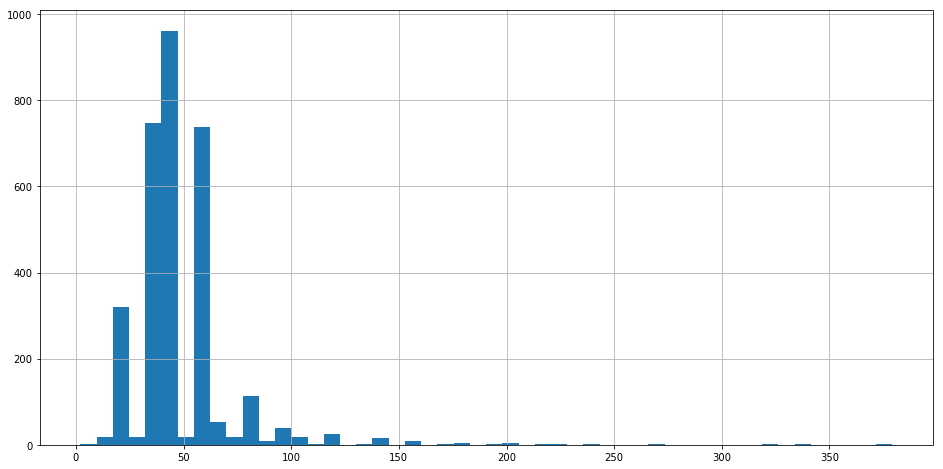

time: 216 ms


In [19]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

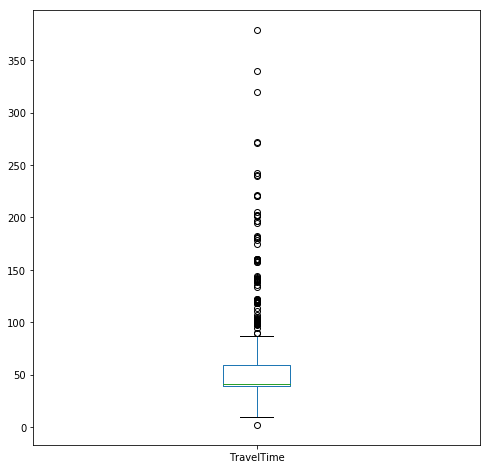

time: 127 ms


In [20]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [21]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    3148.000000
mean       48.778907
std        25.506899
min         2.000000
25%        39.000000
50%        41.000000
75%        59.000000
max       379.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [22]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

19.4745561619
time: 33 ms


In [23]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 227 outliers dropped.
time: 12 ms


In [24]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,99,0.000000,7.5,62,0,Wednesday,18
1,99,0.000000,12.0,62,0,Saturday,12
2,99,0.000000,13.5,62,1,Wednesday,20
3,99,0.000000,18.0,62,1,Wednesday,8
4,99,0.000000,15.0,62,1,Wednesday,19
5,99,0.000000,3.0,86,0,Wednesday,8
6,99,0.000000,11.5,44,0,Friday,15
7,99,0.000000,12.0,48,0,Wednesday,15
8,99,0.000000,15.0,62,0,Tuesday,8
9,99,0.000000,3.0,62,0,Friday,12


time: 58 ms


In [25]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    2921.000000
mean       46.295789
std        14.187135
min        20.000000
25%        39.000000
50%        41.000000
75%        59.000000
max        99.000000
Name: TravelTime, dtype: float64

time: 8 ms


#### Visualising range of data after dropping outliers

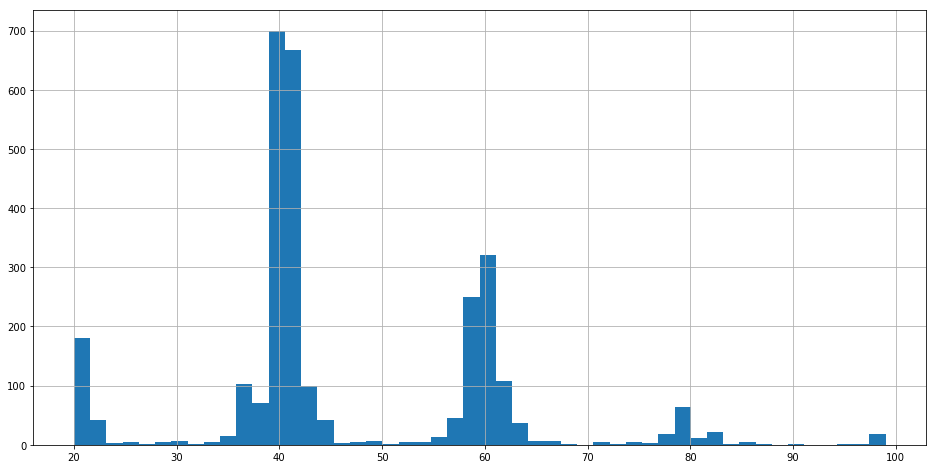

time: 219 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

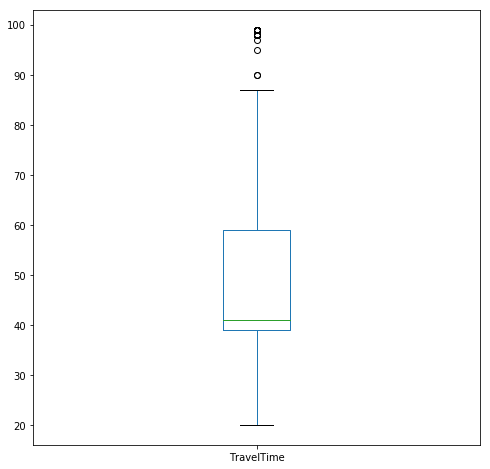

time: 126 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

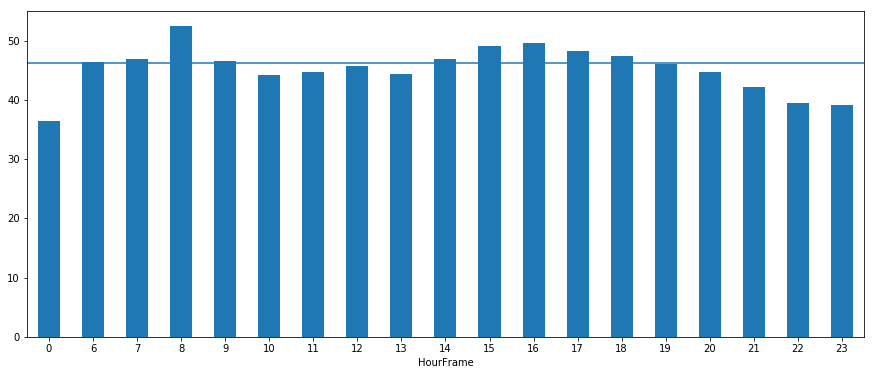

time: 182 ms


In [28]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

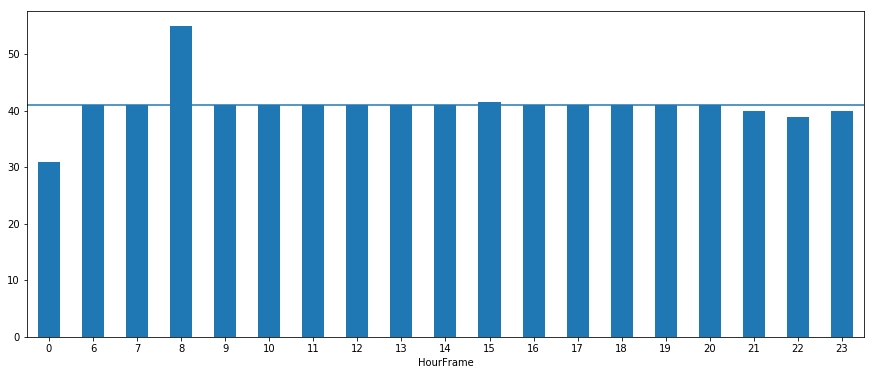

time: 180 ms


In [29]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

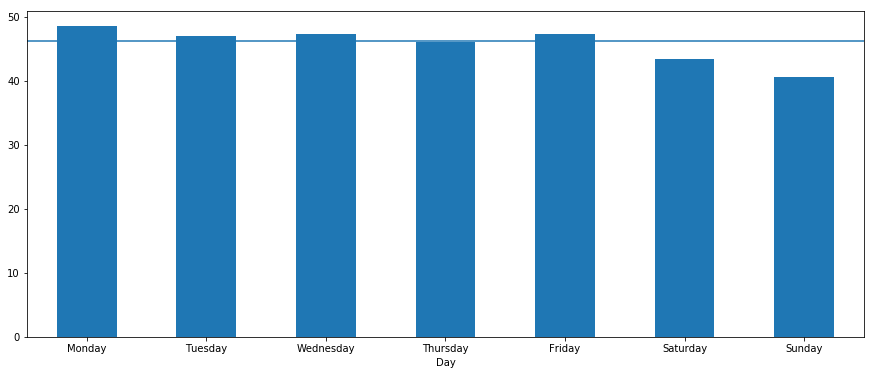

time: 142 ms


In [30]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

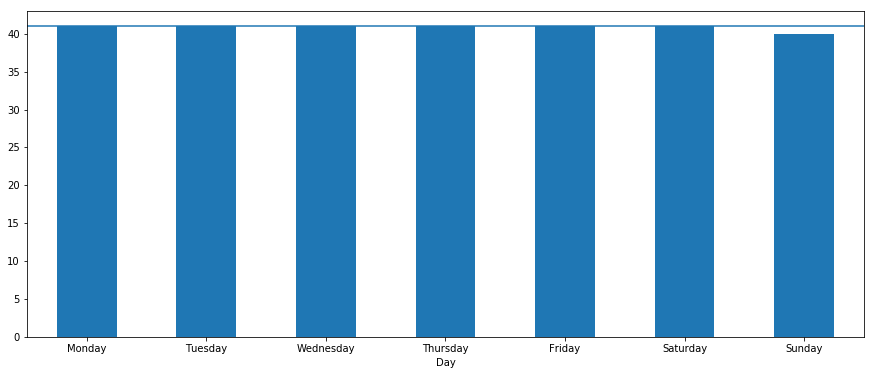

time: 189 ms


In [31]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

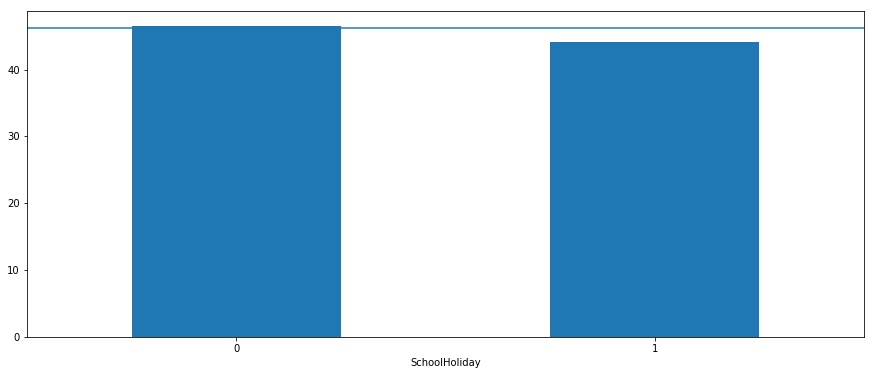

time: 121 ms


In [32]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

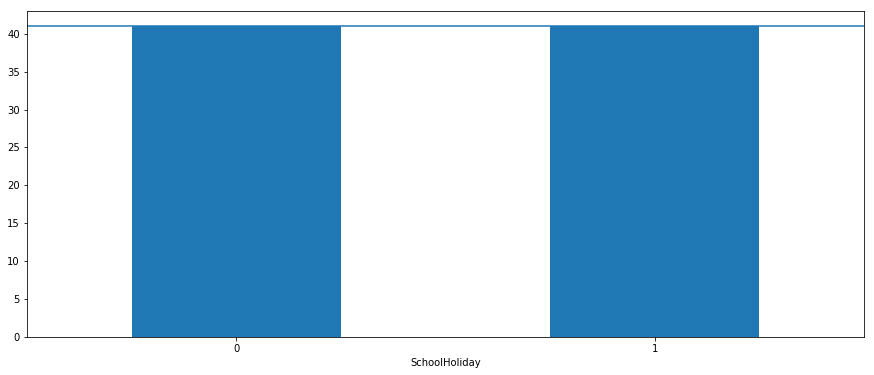

time: 129 ms


In [33]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [34]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,99,0.000000,7.5,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,99,0.000000,12.0,62,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,99,0.000000,13.5,62,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,99,0.000000,18.0,62,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,99,0.000000,15.0,62,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,99,0.000000,3.0,86,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,99,0.000000,11.5,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,99,0.000000,12.0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,99,0.000000,15.0,62,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9,99,0.000000,3.0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 51 ms


In [35]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 3 ms


In [36]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 6 ms


In [37]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 3 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [38]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 17 ms


In [39]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.0779807398205
time: 103 ms


In [40]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 10.6647559193
The mean absolute percentage error is 23.03612515
time: 2 ms


In [41]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.89245110759
The median absolute percentage error is 21.6889051405
time: 2 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [42]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.0422092427657
time: 3 ms


In [43]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 11.1997412476
The mean absolute percentage error is 24.1917061186
time: 2 ms


In [44]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.81628054503
The median absolute percentage error is 21.5031232806
time: 2 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [45]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 223 ms


In [46]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is -0.108347744739
time: 146 ms


In [47]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.77234508133
The mean absolute percentage error is 21.1084966225
time: 3 ms


In [48]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 2.99978064643
The median absolute percentage error is 7.31653816202
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [49]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is -0.0978179234495
time: 65 ms


In [50]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 10.1024450542
The mean absolute percentage error is 21.8215203752
time: 3 ms


In [51]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 2.8999765673
The median absolute percentage error is 7.07311357879
time: 4 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [52]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 100 ms


In [53]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.258506136556
Rain 	 0.152369690401
JPID_length 	 0.0791875992215
Day_Sunday 	 0.0471127203207
Day_Wednesday 	 0.0468517826206
SchoolHoliday 	 0.0460988115846
Day_Saturday 	 0.0431733631785
HF_22 	 0.0317945149877
HF_15 	 0.031144858776
HF_23 	 0.0291480161275
Day_Monday 	 0.0270416212752
HF_10 	 0.0238947655338
HF_8 	 0.0224729127231
Day_Thursday 	 0.0202487030776
HF_7 	 0.020151469618
HF_16 	 0.0186034116892
Day_Tuesday 	 0.0148304322065
HF_21 	 0.0124406171732
HF_9 	 0.011842585241
HF_12 	 0.00989402322102
HF_20 	 0.00962287048302
HF_18 	 0.00953423868489
HF_13 	 0.0070495212436
HF_17 	 0.0070255476197
HF_19 	 0.00654188930499
HF_11 	 0.00480306807903
HF_14 	 0.00435722129552
HF_6 	 0.00425760775728
time: 65 ms


In [54]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.173850801965
time: 5 ms


In [55]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 10.0569309892
The mean absolute percentage error is 21.7232089177
time: 2 ms


In [56]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 8.24876929547
The median absolute percentage error is 20.1189495011
time: 3 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [57]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.0264904722717
time: 3 ms


In [58]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 11.2687474987
The mean absolute percentage error is 24.3407612539
time: 2 ms


In [59]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 8.66751158878
The median absolute percentage error is 21.1402721677
time: 4 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [60]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 113 ms


In [61]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.314353835318
JPID_length 	 0.131600211052
Rain 	 0.0837793589626
Day_Thursday 	 0.0370510826083
Day_Wednesday 	 0.0326789701278
Day_Tuesday 	 0.0326649932581
SchoolHoliday 	 0.0324370589799
Day_Sunday 	 0.0261492423463
Day_Saturday 	 0.0260260752629
HF_9 	 0.0205077698569
Day_Monday 	 0.020473642755
HF_23 	 0.019419101745
HF_8 	 0.0177052294137
HF_19 	 0.0176962104224
HF_14 	 0.0174298442355
HF_7 	 0.0164300400643
HF_18 	 0.0159507428735
HF_22 	 0.0158466212168
HF_20 	 0.0158399545543
HF_16 	 0.0153023536531
HF_15 	 0.0141181360635
HF_17 	 0.0134381084974
HF_11 	 0.01332757323
HF_12 	 0.0129713945439
HF_13 	 0.0124966035927
HF_21 	 0.0115945637808
HF_10 	 0.00978673649965
HF_6 	 0.00292454508563
time: 2.94 s


In [62]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.572513424297
time: 103 ms


In [63]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 6.51286088979
The mean absolute percentage error is 14.0679336383
time: 2 ms


In [64]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 4.67170634921
The median absolute percentage error is 11.3944057298
time: 3 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [65]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is -0.173902380033
time: 105 ms


In [66]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 11.9678674635
The mean absolute percentage error is 14.0679336383
time: 2 ms


In [67]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 9.4
The median absolute percentage error is 22.9268292683
time: 3 ms


## 4 Both Tree models - parameter tuning with RandomizedSearchCV

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [68]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

time: 6 ms


In [69]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001FFEF4A8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000200FE6D8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000200FE5C0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000200FE748>, 'learning_rate': <scipy.stats._distn_in

time: 14min 18s


In [70]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.057056127723915565, 'max_depth': 5, 'min_samples_leaf': 90, 'min_samples_split': 827, 'n_estimators': 1589}
time: 1e+03 µs


In [71]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 8.61831308483
Best MdAPE found is 21.02%
time: 3 ms


In [72]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-7.894752,-8.618313,1589,5,90,827,0.0570561,2.4534,0.0110
1,2,-8.193543,-8.627606,186,7,61,819,0.0585175,0.4064,0.0020
2,3,-8.035667,-8.640303,1113,4,73,860,0.0477104,1.5652,0.0062
3,4,-7.877582,-8.684277,880,7,73,981,0.107472,1.3940,0.0094
4,5,-7.808211,-8.705306,504,5,77,369,0.0973909,1.2366,0.0124
5,6,-8.171028,-8.729086,1138,4,46,652,0.0230651,1.6520,0.0062
6,7,-7.910577,-8.730632,1264,8,95,832,0.0533957,2.1130,0.0092
7,8,-7.671645,-8.765358,375,7,51,354,0.0882671,0.9562,0.0042
8,9,-7.778192,-8.770970,177,5,22,477,0.213652,0.3112,0.0020
9,10,-7.831010,-8.808435,508,5,99,593,0.183227,0.8718,0.0040


time: 41 ms


In [73]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 8.57986413074
MdAPE of best model on the test set is 20.926%
time: 30 ms


### 4b Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [76]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(2, 100)}

time: 5 ms


In [77]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002085B390>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002085B080>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020843400>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002085B630>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sc

time: 14min 4s


In [78]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 63, 'n_estimators': 750}
time: 1 ms


In [79]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 8.48366444601
Best MdAPE found is 20.692%
time: 3 ms


In [80]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-8.468957,-8.483664,750,4,17,63,1.2154,0.0344
1,2,-8.467777,-8.493370,4693,4,2,45,7.0866,0.2296
2,3,-8.462545,-8.499834,3886,4,15,58,5.5164,0.1778
3,4,-8.446819,-8.505682,1197,4,19,14,1.7822,0.0542
4,5,-8.450279,-8.507115,3770,4,1,58,5.4348,0.1696
5,6,-8.462217,-8.507957,3102,4,2,62,4.4864,0.1396
6,7,-8.464711,-8.508028,3497,4,19,44,4.9596,0.1586
7,8,-8.431109,-8.508062,2152,4,8,22,3.3196,0.1160
8,9,-8.439292,-8.508730,1524,4,7,52,2.5272,0.0784
9,10,-8.461873,-8.512193,2659,4,1,72,4.2566,0.1370


time: 36 ms


In [81]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 8.55297895944
MdAPE of best model on the test set is 20.861%
time: 45 ms
